# math 519 project notebook

Conditioning, OLS, ridge, and logistic regression.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond

In [58]:
np.random.seed(0) 

X = np.random.randn(200, 20)   
beta_true = np.random.randn(20) 
noise = 0.1 * np.random.randn(200) 
y = X @ beta_true + noise       

print("Condition number of X:", cond(X))
print("First 5 values of y:", y[:5])

Condition number of X: 1.703051197787162
First 5 values of y: [-2.4307426  -5.49401837  0.93889084 -2.7802066  -8.99570186]


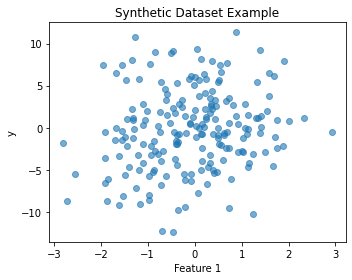

In [59]:
plt.figure(figsize=(5,4))
plt.scatter(X[:,0], y, alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("y")
plt.title("Synthetic Dataset Example")
plt.tight_layout()
plt.savefig("synthetic_data_example.png", dpi=300)

In [60]:
# ordinary least squares solution
XtX = X.T @ X
Xty = X.T @ y
beta_ols = np.linalg.inv(XtX) @ Xty

print("Estimated coefficients (first 5):", beta_ols[:5])
print("True coefficients (first 5):     ", beta_true[:5])

Estimated coefficients (first 5): [ 0.61845122  1.84002526  0.27128582  1.14240681 -1.74462582]
True coefficients (first 5):      [ 0.61334917  1.84369998  0.27109098  1.13644763 -1.73833187]


In [61]:
error = np.linalg.norm(beta_ols - beta_true)
print("Parameter estimation error:", error)

Parameter estimation error: 0.03209770223469925


In [62]:
U, s, Vt = np.linalg.svd(X, full_matrices=False)
s[-1] = 1e-6   # shrink the smallest singular value
X_bad = U @ np.diag(s) @ Vt

beta_ols_bad = np.linalg.inv(X_bad.T @ X_bad) @ (X_bad.T @ y)

error_bad = np.linalg.norm(beta_ols_bad - beta_true)

print("Condition number of X_bad:", cond(X_bad))
print("Parameter estimation error:", error_bad)

Condition number of X_bad: 17148258.60028229
Parameter estimation error: 9160524.241848685


In [63]:
print("Condition numbers:")
print(f"  cond(X)     = {cond(X):.2e}")
print(f"  cond(X_bad) = {cond(X_bad):.2e}")


Condition numbers:
  cond(X)     = 1.70e+00
  cond(X_bad) = 1.71e+07


In [64]:
print("OLS parameter error on well-conditioned X:")
print(f"  ||beta_hat - beta_true||_2 (good X) = {error:.3e}")
print("OLS parameter error on ill-conditioned X_bad:")
print(f"  ||beta_hat - beta_true||_2 (bad X)  = {error_bad:.3e}")


OLS parameter error on well-conditioned X:
  ||beta_hat - beta_true||_2 (good X) = 3.210e-02
OLS parameter error on ill-conditioned X_bad:
  ||beta_hat - beta_true||_2 (bad X)  = 9.161e+06


In [65]:
lam = 1.0 

ridge_matrix = X_bad.T @ X_bad + lam * np.eye(X_bad.shape[1])
beta_ridge = np.linalg.inv(ridge_matrix) @ (X_bad.T @ y)

error_ridge = np.linalg.norm(beta_ridge - beta_true)

print("Ridge parameter estimation error:", error_ridge)

Ridge parameter estimation error: 0.9148071866279041


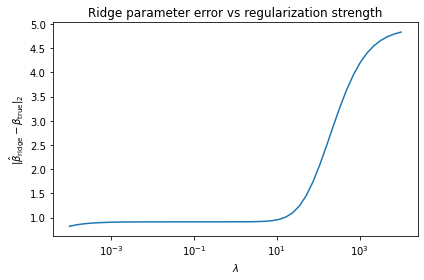

In [66]:
lams = np.logspace(-4, 4, 50)  # 10^-4 to 10^4
errors = []

for lam in lams:
    ridge_matrix = X_bad.T @ X_bad + lam * np.eye(X_bad.shape[1])
    beta_ridge = np.linalg.inv(ridge_matrix) @ (X_bad.T @ y)
    errors.append(np.linalg.norm(beta_ridge - beta_true))

plt.figure(figsize=(6,4))
plt.semilogx(lams, errors)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\|\hat\beta_{\mathrm{ridge}} - \beta_{\mathrm{true}}\|_2$")
plt.title("Ridge parameter error vs regularization strength")
plt.tight_layout()
plt.show()

In [67]:
# generate binary labels for logistic regression
logits = X_bad @ beta_true
probs = 1 / (1 + np.exp(-logits))
y_class = (probs > 0.5).astype(int)

print("Class balance:", np.mean(y_class))

Class balance: 0.47


In [68]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_loss(beta):
    eps = 1e-12
    z   = X_bad @ beta
    p   = sigmoid(z)
    return -np.mean(y_class * np.log(p + eps) + (1 - y_class) * np.log(1 - p + eps))

def logistic_grad(beta):
    z = X_bad @ beta
    return X_bad.T @ (sigmoid(z) - y_class) / len(y_class)

beta_log = np.zeros(X_bad.shape[1])
alpha = 0.01  # learning rate

loss_history = []
for _ in range(2000):
    loss_history.append(logistic_loss(beta_log))
    beta_log -= alpha * logistic_grad(beta_log)

print("Estimated logistic coefficients (first 5):", beta_log[:5])
print("True coefficients (first 5):             ", beta_true[:5])

err_log = np.linalg.norm(beta_log - beta_true)
print("Logistic parameter estimation error:", err_log)


Estimated logistic coefficients (first 5): [ 0.46003762  0.82964967  0.02847741  0.74061227 -0.73809217]
True coefficients (first 5):              [ 0.61334917  1.84369998  0.27109098  1.13644763 -1.73833187]
Logistic parameter estimation error: 2.5816742881616195


In [69]:
err_log = np.linalg.norm(beta_log - beta_true)
print("Logistic parameter estimation error:", err_log)

Logistic parameter estimation error: 2.5816742881616195


In [70]:
def logistic_loss_l2(beta, lam):
    eps = 1e-12
    z   = X_bad @ beta
    p   = sigmoid(z)
    data_term = -np.mean(y_class * np.log(p + eps) + (1 - y_class) * np.log(1 - p + eps))
    reg_term  = 0.5 * lam * np.linalg.norm(beta)**2
    return data_term + reg_term

def logistic_grad_l2(beta, lam):
    z = X_bad @ beta
    grad_data = X_bad.T @ (sigmoid(z) - y_class) / len(y_class)
    grad_reg  = lam * beta
    return grad_data + grad_reg

lam = 1.0
beta_log_ridge = np.zeros(X_bad.shape[1])
alpha = 0.01

for _ in range(2000):
    beta_log_ridge -= alpha * logistic_grad_l2(beta_log_ridge, lam)

err_log_ridge = np.linalg.norm(beta_log_ridge - beta_true)
print("Unregularized logistic error:", err_log)
print("L2-regularized logistic error:", err_log_ridge)


Unregularized logistic error: 2.5816742881616195
L2-regularized logistic error: 4.622067467580293


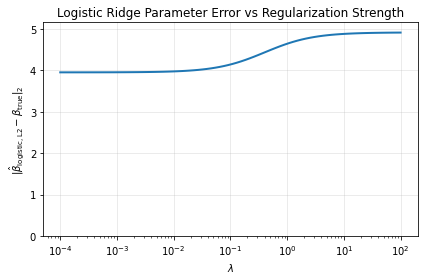

In [71]:
# --- Logistic Ridge: parameter error vs lambda ---

lams = np.logspace(-4, 2, 80)   
errors_logistic = []

for lam in lams:
    beta_tmp = np.zeros(X_bad.shape[1])
    # smaller step for larger lambda to avoid explosion
    alpha = 0.01 / (1.0 + lam)

    for _ in range(400):       # enough to converge but not blow up
        beta_tmp -= alpha * logistic_grad_l2(beta_tmp, lam)

    err_tmp = np.linalg.norm(beta_tmp - beta_true)
    errors_logistic.append(err_tmp)

plt.figure(figsize=(6,4))
plt.semilogx(lams, errors_logistic, linewidth=2)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\|\hat\beta_{\mathrm{logistic,L2}} - \beta_{\mathrm{true}}\|_2$")
plt.title("Logistic Ridge Parameter Error vs Regularization Strength")
plt.grid(alpha=0.3)

y_max = max(errors_logistic)
plt.ylim(0, 1.05 * y_max)

plt.tight_layout()
plt.show()


In [72]:
def accuracy(Xmat, beta, y_labels):
    preds = (sigmoid(Xmat @ beta) > 0.5).astype(int)
    return np.mean(preds == y_labels)

acc_unreg = accuracy(X_bad, beta_log, y_class)
acc_reg = accuracy(X_bad, beta_log_ridge, y_class)

print("Accuracy unregularized:", acc_unreg)
print("Accuracy regularized:", acc_reg)

Accuracy unregularized: 0.97
Accuracy regularized: 0.935


In [73]:
epsilon = 0.05
DeltaX = epsilon * np.random.randn(*X_bad.shape)
X_pert = X_bad + DeltaX

acc_unreg_pert = accuracy(X_pert, beta_log, y_class)
acc_reg_pert = accuracy(X_pert, beta_log_ridge, y_class)

print("Accuracy unregularized on perturbed X:", acc_unreg_pert)
print("Accuracy regularized on perturbed X:", acc_reg_pert)

Accuracy unregularized on perturbed X: 0.97
Accuracy regularized on perturbed X: 0.945


In [74]:
print("Logistic regression coefficient errors:")
print(f"  Unregularized: ||beta_hat - beta_true||_2 = {err_log:.3e}")
print(f"  L2 regularized: ||beta_hat - beta_true||_2 = {err_log_ridge:.3e}")


Logistic regression coefficient errors:
  Unregularized: ||beta_hat - beta_true||_2 = 2.582e+00
  L2 regularized: ||beta_hat - beta_true||_2 = 4.622e+00


In [75]:
print("Accuracy without regularization:")
print(f"  Original features:  {acc_unperturbed:.3f}")
print(f"  Perturbed features: {acc_perturbed:.3f}")


Accuracy without regularization:
  Original features:  0.970
  Perturbed features: 0.970


In [76]:
from sklearn.metrics import accuracy_score

# predictions on original X_bad
y_pred_orig = (sigmoid(X_bad @ beta_log) >= 0.5).astype(int)
acc_unperturbed = accuracy_score(y_class, y_pred_orig)

# perturbed matrix
X_pert = X_bad + 0.05 * np.random.randn(*X_bad.shape)

# predictions on perturbed X
y_pred_pert = (sigmoid(X_pert @ beta_log) >= 0.5).astype(int)
acc_perturbed = accuracy_score(y_class, y_pred_pert)

In [77]:
from sklearn.linear_model import LinearRegression, Ridge

# --- OLS and Ridge with scikit-learn on well-conditioned X ---

# manual implementation
XtX = X.T @ X
Xty = X.T @ y
beta_ols = np.linalg.inv(XtX) @ Xty

lam = 1.0
ridge_matrix = XtX + lam * np.eye(X.shape[1])
beta_ridge = np.linalg.inv(ridge_matrix) @ Xty

ols_sklearn = LinearRegression(fit_intercept=False)
ols_sklearn.fit(X, y)
beta_ols_sk = ols_sklearn.coef_

ridge_sklearn = Ridge(alpha=lam, fit_intercept=False)
ridge_sklearn.fit(X, y)
beta_ridge_sk = ridge_sklearn.coef_

# residual norms
res_ols = np.linalg.norm(X @ beta_ols - y)
res_ols_sk = np.linalg.norm(X @ beta_ols_sk - y)
res_ridge = np.linalg.norm(X @ beta_ridge - y)
res_ridge_sk = np.linalg.norm(X @ beta_ridge_sk - y)

print("=== Well-conditioned X ===")
print("Manual OLS vs scikit-learn OLS (coef diff):      ",
      np.linalg.norm(beta_ols - beta_ols_sk))
print("Manual Ridge vs scikit-learn Ridge (coef diff): ",
      np.linalg.norm(beta_ridge - beta_ridge_sk))
print("Residual norms:")
print("  OLS (manual, sklearn):   ", res_ols, res_ols_sk)
print("  Ridge (manual, sklearn): ", res_ridge, res_ridge_sk)

# --- OLS and Ridge with scikit-learn on ill-conditioned X_bad ---

XtX_bad = X_bad.T @ X_bad
Xty_bad = X_bad.T @ y
beta_ols_bad = np.linalg.inv(XtX_bad) @ Xty_bad

ridge_matrix_bad = XtX_bad + lam * np.eye(X_bad.shape[1])
beta_ridge_bad = np.linalg.inv(ridge_matrix_bad) @ Xty_bad

ols_sklearn_bad = LinearRegression(fit_intercept=False)
ols_sklearn_bad.fit(X_bad, y)
beta_ols_bad_sk = ols_sklearn_bad.coef_

ridge_sklearn_bad = Ridge(alpha=lam, fit_intercept=False)
ridge_sklearn_bad.fit(X_bad, y)
beta_ridge_bad_sk = ridge_sklearn_bad.coef_

res_ols_bad = np.linalg.norm(X_bad @ beta_ols_bad - y)
res_ols_bad_sk = np.linalg.norm(X_bad @ beta_ols_bad_sk - y)
res_ridge_bad = np.linalg.norm(X_bad @ beta_ridge_bad - y)
res_ridge_bad_sk = np.linalg.norm(X_bad @ beta_ridge_bad_sk - y)

print("\n=== Ill-conditioned X_bad ===")
print("Manual OLS vs scikit-learn OLS (coef diff):      ",
      np.linalg.norm(beta_ols_bad - beta_ols_bad_sk))
print("Manual Ridge vs scikit-learn Ridge (coef diff): ",
      np.linalg.norm(beta_ridge_bad - beta_ridge_bad_sk))
print("Residual norms:")
print("  OLS (manual, sklearn):   ", res_ols_bad, res_ols_bad_sk)
print("  Ridge (manual, sklearn): ", res_ridge_bad, res_ridge_bad_sk)

=== Well-conditioned X ===
Manual OLS vs scikit-learn OLS (coef diff):       7.199884053450224e-15
Manual Ridge vs scikit-learn Ridge (coef diff):  2.199664937290724e-15
Residual norms:
  OLS (manual, sklearn):    1.3831267463152088 1.3831267463152082
  Ridge (manual, sklearn):  1.43440686296671 1.434406862966711

=== Ill-conditioned X_bad ===
Manual OLS vs scikit-learn OLS (coef diff):       90381.75165758352
Manual Ridge vs scikit-learn Ridge (coef diff):  6.08095775056179e-14
Residual norms:
  OLS (manual, sklearn):    1.53187314512053 1.383126748899598
  Ridge (manual, sklearn):  9.361016946362541 9.361016946362536


In [78]:
from sklearn.linear_model import LogisticRegression


def logistic_loss(beta):
    z = X_bad @ beta
    p = sigmoid(z)
    return -np.mean(y_class * np.log(p) + (1 - y_class) * np.log(1 - p))

def logistic_grad(beta):
    z = X_bad @ beta
    return X_bad.T @ (sigmoid(z) - y_class) / len(y_class)

# gradient descent monitoring
beta_log = np.zeros(X_bad.shape[1])
alpha = 0.01
num_iters = 2000
loss_history = []

for _ in range(num_iters):
    loss_history.append(logistic_loss(beta_log))
    beta_log -= alpha * logistic_grad(beta_log)

print("Final logistic loss (our GD):", loss_history[-1])

# compare to scikit-learn logistic regression (L2, no intercept)
log_sklearn = LogisticRegression(
    penalty="l2",
    C=1.0,   # inverse of regularization strength; here effectively unregularized
    fit_intercept=False,
    solver="lbfgs",
    max_iter=10000
)
log_sklearn.fit(X_bad, y_class)
beta_log_sk = log_sklearn.coef_.ravel()

print("Coefficient difference (our GD vs sklearn):",
      np.linalg.norm(beta_log - beta_log_sk))

# simple singular value analysis
U_x, s_x, Vt_x = np.linalg.svd(X, full_matrices=False)
U_bad, s_bad, Vt_bad = np.linalg.svd(X_bad, full_matrices=False)

print("\nSingular values (first 5) for X:", s_x[:5])
print("Smallest singular value for X:", s_x[-1])
print("\nSingular values (first 5) for X_bad:", s_bad[:5])
print("Smallest singular value for X_bad:", s_bad[-1])
print("Condition numbers: X =", s_x[0]/s_x[-1], ", X_bad =", s_bad[0]/s_bad[-1])

Final logistic loss (our GD): 0.20771128309177622
Coefficient difference (our GD vs sklearn): 2.123698580547587

Singular values (first 5) for X: [17.14825861 17.02961544 16.53699457 16.08410753 15.91386871]
Smallest singular value for X: 10.069138631340634

Singular values (first 5) for X_bad: [17.14825861 17.02961544 16.53699457 16.08410753 15.91386871]
Smallest singular value for X_bad: 1.0000000003794786e-06
Condition numbers: X = 1.7030511977871647 , X_bad = 17148258.60028228


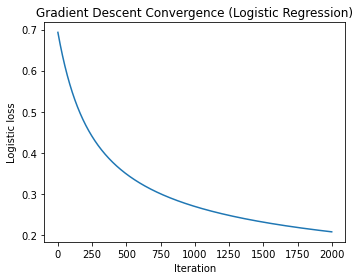

In [79]:
plt.figure(figsize=(5,4))
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Logistic loss")
plt.title("Gradient Descent Convergence (Logistic Regression)")
plt.tight_layout()
plt.savefig("logistic_loss_convergence.png", dpi=300)
plt.show()